<center><b><font size="+3">FAKE NEWS DETECTION</font></b></center>

<center>
    <img src="https://miro.medium.com/max/3840/1*CQaCf35n3pReVZ02iYK0Xg.jpeg" width="1600" height="600" alt="cognitiveclass.ai logo"  />
</center>

# Thông tin thành viên và phân công nhiệm vụ

|MSSV    | HO TEN               | NHIEM VU    |
|:-------|:---------------------|:-----------:|
|19110102| Nguyễn Bùi Duy Phong | Tiền xử lí dữ liệu    |
|19110136| Trần Văn Thiên       | Tiền xử lí dữ liệu    |
|19110080| Phạm Văn Mạnh Hùng   | Mô hình hóa           |
|19110133| Đỗ Trần Công Phương  | LogisticRegressionCV  |
|19110133| Nguyễn Nhiêu Thịnh   | DecisionTreeClassifier|
|19110133| Trần Duy Thống       | Design streamlit      |

# Import các thư viện cần thiết

In [50]:
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Thư viện ngoài
from pyvi import ViTokenizer 

`pyvi` là thư viện ngoài. Em dùng để `Tokenizer` văn bản tiếng việt. Thầy cô chỉ cần cài bằng cách `pip install pyvi`. Thông tin chi tiết [tại đây](https://towardsdatascience.com/introduction-to-pyvi-python-vietnamese-nlp-toolkit-ff5124983dc2)

# Nguồn dữ liệu

File `vn_news_223_tdlfr.csv` được lấy từ [VNFD Dataset](https://github.com/thanhhocse96/vfnd-vietnamese-fake-news-datasets/blob/master/CSV/vn_news_223_tdlfr.csv)
- Tập dữ liệu 223 record bản tin tiếng Việt, gồm 2 nhãn: 1 (tin giả) và 0 (tin thật) 
- Mô tả dữ liệu: file `vietnamese-stopwords.txt` được lấy từ [VNFD](https://github.com/thanhhocse96/vfnd-vietnamese-fake-news-datasets/tree/master/CSV)

File `vietnamese-stopwords.txt` chứa các từ `stopword` được lấy từ [VNStopword](https://github.com/stopwords/vietnamese-stopwords/blob/master/vietnamese-stopwords.txt)

# Tiền xử lý văn bản tiếng Việt

Dữ liệu được lấy từ file `vn_news_223_tdlfr.csv`

In [2]:
news_df = pd.read_csv('vn_news_223_tdlfr.csv', encoding='utf-8')
news_df.sample(5)

,text,domain,label
27,"Rùa biển sa lưới ‘vươn cổ cúi lạy’, ông chủ bè...",thoibao.today,1
207,Federer đụng Djokovic ở bán kết Giải quần vợt ...,thethao.tuoitre.vn,0
218,“Siêu máy bay” A350 sẽ chở CĐV Việt Nam đi Mal...,dantri.com.vn,0
122,"Bị cảnh báo giả, khách trên máy bay TP.HCM đi ...",tuoitre.vn,0
147,Ba du khách tử vong ở Đà Nẵng trúng chất độc ả...,vnexpress.net,0


## Dữ liệu có bị trùng lặp hay không? Nếu có thì loại bỏ chúng

In [3]:
len(news_df) - len(news_df.drop_duplicates())

1

Vậy dữ liệu có 1 dòng bị trùng. Ta sẽ tiến hành loại bỏ nó.

In [4]:
news_df = news_df.drop_duplicates()
news_df.shape

(222, 3)

In [5]:
assert len(news_df) == len(news_df.drop_duplicates())

## Tiền xử lí cơ bản

### Đọc file `vietnamese-stopwords.txt` để lưu 1 set các từ stopword

In [6]:
stopword = open('./vietnamese-stopwords.txt', 'r',encoding='utf-8')
stopword = set([i.rstrip() for i in stopword.readlines()])

### Hàm loại bỏ các dấu câu, lowercase và loại stopword

- Trước tiên, em sẽ định nghĩa các kí hiệu `noise`.
- Sau đó thay thế khoảng trắng giữa các stopword bằng dấu `_`. Lý do: vì khi tokenize chữ thì các cụm từ có dấu`_`  nối giữa các từ.
- Tiếp theo, là các bước loại bỏ các kí hiệu `noise`, `tokenizer`,`lowercase` và loại bỏ `stopword` trong phần text
- Cuối cùng, đó là thêm phần tên miền vào list `clean_test`

In [7]:
puncs = string.punctuation + '\n“”‘’'
puncs

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~\n“”‘’'

In [8]:
stopword = pd.Series(list(stopword)).str.replace(' ', '_').to_list()
stopword[:5]

['nhìn_xuống', 'rày', 'cơn', 'cũng_nên', 'trả_trước']

In [9]:
def remove_stopword(x):
     return [i.rstrip('_') for i in x if i not in stopword and i not in [',', '']]
    
clean_text = news_df['text'].replace(f'[{puncs}]', ',', regex=True).\
            apply(ViTokenizer.tokenize).str.lower().\
            str.split().apply(remove_stopword)

clean_text.sample(5)

115    [55, tỷ, đồng, nâng_cấp, 8,5, km, đại_lộ, võ_v...
10     [khẩn_cấp, hàng_loạt, trẻ_em, nhập_viện, ngộ_đ...
129    [thu, lái, 2, phi_công, vietjet, sự_cố, máy_ba...
213    [đòi, nợ, 60, triệu, ép, nạn_nhân, viết, giấy,...
32     [đi, đêm, mẹ, tá_hoả, mặt, cắt, nát, kinh_dị, ...
Name: text, dtype: object

In [10]:
news_df['clean_text'] = clean_text
news_df['clean_text'] = news_df.apply(lambda x: ' '.join(x['clean_text']) + ' ' + x['domain'], axis=1)

news_df.head(5)

,text,domain,label,clean_text
0,Thủ tướng Abe cúi đầu xin lỗi vì hành động phi...,binhluan.biz,1,thủ_tướng abe cúi đầu xin_lỗi hành_động phi th...
1,Thủ tướng Nhật cúi đầu xin lỗi vì tinh thần ph...,www.ipick.vn,1,thủ_tướng nhật cúi đầu xin_lỗi tinh_thần phi t...
2,Choáng! Cơ trưởng đeo khăn quàng quẩy banh nóc...,tintucqpvn.net,1,choáng cơ_trưởng đeo khăn_quàng quẩy banh sân_...
3,Chưa bao giờ nhạc Kpop lại dễ hát đến thế!!!\n...,tintucqpvn.net,1,nhạc kpop hát giáo_sư nguyễn_lân dũng thành_đạ...
4,"Đại học Hutech sẽ áp dụng cải cách ""Tiếq Việt""...",www.gioitreviet.net,1,đại_học hutech áp_dụng cải_cách tiếq việt năm_...


# Khám phá dữ liệu

## Dữ liệu có bao nhiêu dòng cột?

In [11]:
news_df.shape

(222, 4)

In [12]:
print(f"Vậy dữ liệu có {news_df.shape[0]} dòng và {news_df.shape[1]} cột.")

Vậy dữ liệu có 222 dòng và 4 cột.


## Dữ liệu có bị thiếu hay không?

In [13]:
news_df.isnull().sum()

text          0
domain        0
label         0
clean_text    0
dtype: int64

## Các kiểu dữ liệu của các cột đã phù hợp hay chưa?

In [14]:
news_df.dtypes

text          object
domain        object
label          int64
clean_text    object
dtype: object

*Nhìn qua ta có thể thấy các cột dữ liệu đã có kiểu dữ liệu thích hợp. Tuy nhiên để chắc chắn hơn ta cần kiểm tra cột dữ liệu ở các cột `text`, `domain`, vì kiểu dữ liệu object có thể có nhiều kiểu dữ liệu khác nhau trong đó*

In [15]:
def open_object_dtype(s):
    dtypes = set()
    s.apply(lambda x: dtypes.add(type(x)))
    return dtypes

In [16]:
#TEST
assert open_object_dtype(news_df['text']) == {str}
assert open_object_dtype(news_df['domain']) == {str}

*Vậy là các cột dữ liệu thuộc kiểu object đều có dạng chuỗi, thỏa với mục đích cần tìm*

## Các giá trị trong cột dữ liệu `label` có sự phân bố như thế nào?

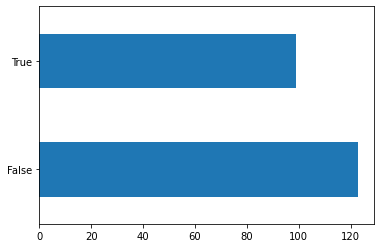

In [17]:
news_df['label'].value_counts().rename(index={0:'False', 1:'True'}).plot.barh();

## Sự phân bố của cột dữ liệu `domain`

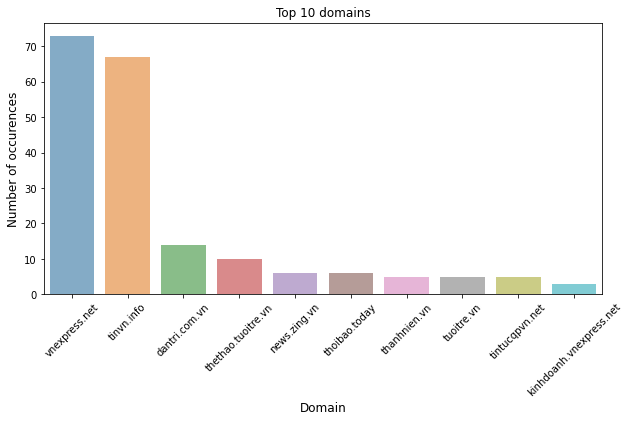

In [18]:
top_ten_domain = news_df['domain'].value_counts()[:10]

plt.figure(figsize=(10,5))
sns.barplot(x=top_ten_domain.index, y=top_ten_domain.values, alpha=0.6)
plt.title('Top 10 domains')
plt.xlabel('Domain', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('Number of occurences', fontsize=12);

## Khám phá cột dữ liệu `text`

- Thông tin thống kê của văn bản

In [19]:
#Lấy các thông tin thống kê của văn bản 
text_col = news_df['text'].apply(lambda x: len(x))

def lower_quantile(df):
    return df.quantile(0.25).round()
def median(df):
    return df.quantile(0.5).round()
def upper_quantile(df):
    return df.quantile(0.75).round()

text_col.agg(['min', lower_quantile, median, upper_quantile, 'max'])

min                 309.0
lower_quantile     1280.0
median             1988.0
upper_quantile     3285.0
max               10019.0
Name: text, dtype: float64

# Mô hình hóa

## Tokenize văn bản

In [20]:
train_data = TfidfVectorizer(lowercase=False).fit_transform(news_df['clean_text'])

## Chia dữ liệu

Ở phần này, nhóm em quyết định chia tập dữ liệu thành 3 phần:
- Phần train chiếm 75%
- Phần valid data chiếm 15%
- Phần test chiếm 10%

In [21]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

x_train, x_test, y_train, y_test = train_test_split(train_data, news_df.label, test_size=1 - train_ratio, random_state=42)

x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42) 

## Mô hình tuyến tính

Với mô hình tuyến tính, em sử dụng bộ phân lớp `LogisticRegressionCV`

### Tìm mô hình tốt nhất

In [51]:
train_accs = []
val_accs = []
cvs = [5,6,7,8,9,10]
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
best_val_acc = 0
best_cv = None
best_solver = None

for cv in cvs:
    for solver in solvers:
        lg_re = LogisticRegressionCV(Cs=20, cv=cv, solver=solver, max_iter=10000).fit(x_train, y_train)
        val_accs.append(accuracy_score(lg_re.predict(x_val), y_val))
        train_accs.append(accuracy_score(lg_re.predict(x_test), y_test))
        
best_val_acc = max(val_accs)
index_best = val_accs.index(best_val_acc)
best_cv = cvs[index_best // len(solvers)]
best_solver = solvers[index_best % len(solvers)]

In [52]:
lg_re.set_params(cv=best_cv, solver=best_solver).fit(x_train, y_train)

LogisticRegressionCV(Cs=20, cv=5, max_iter=10000, solver='newton-cg')

In [53]:
print(f"Vậy các tham số tốt nhất với mô hình này tìm được là Cs=20, cv={best_cv}, max_iter=1000, solver={best_solver}")

Vậy các tham số tốt nhất với mô hình này tìm được là Cs=20, cv=5, max_iter=1000, solver=newton-cg


In [54]:
accuracy_score(y_true=y_test, y_pred=lg_re.predict(x_test))

0.9565217391304348

**Nhận xét:** Tỉ lệ khớp với tập test khá cao.

### Trực quan hóa kết quả

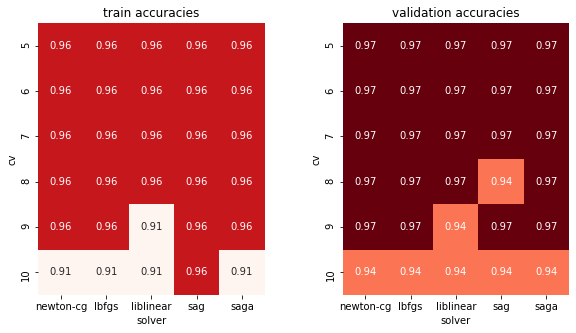

In [56]:
# Trực quan hóa kết quả
train_accs_df = pd.DataFrame(data=np.array(train_accs).reshape(len(cvs), -1),
                             index=cvs, columns=solvers)
val_accs_df = pd.DataFrame(
    data=np.array(val_accs).reshape(len(cvs), -1), 
    index=cvs, columns=solvers)
min_err = min(min(train_accs), min(val_accs))
max_err = max(max(train_accs), max(val_accs))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_accs_df, vmin=min_err, vmax=max_err, square=True, 
            annot=True, cbar=False, fmt='.2f', cmap='Reds')
plt.title('train accuracies'); plt.xlabel('solver'); plt.ylabel('cv')
plt.subplot(1, 2, 2)
sns.heatmap(val_accs_df, vmin=min_err, vmax=max_err, square=True, 
            annot=True, cbar=False, fmt='.2f', cmap='Reds')
plt.title('validation accuracies'); plt.xlabel('solver'); plt.ylabel('cv');

**Nhận xét:** tỉ lệ tập `train` và tập `valid` khá tương đồng nhau. Số `k-fold cross validation` càng nhiều, tỉ lệ chính xác càng giảm, kéo theo giảm bớt hiện tượng overfitting

## Mô hình phi tuyến

Với mô hìn này, em sử dụng bộ phân lớp `DecisionTreeClassifier`

### Tìm mô hình tốt nhất

In [65]:
train_accs = []
val_accs = []
max_features = ['auto', 'sqrt', 'log2', None]
max_leaf_nodes = [30, 100, 300, 1000]
best_val_acc = 0
best_features = None
best_leaf_nodes = None

for max_feature in max_features:
    for max_leaf_node in max_leaf_nodes:
        tree = DecisionTreeClassifier(random_state=42, max_features=max_feature, max_leaf_nodes=max_leaf_node).fit(x_train, y_train)
        val_accs.append(accuracy_score(tree.predict(x_val), y_val))
        train_accs.append(accuracy_score(tree.predict(x_train), y_train))

best_val_acc = max(val_accs)
index_best = val_accs.index(best_val_acc)
best_features = max_features[index_best // len(max_leaf_nodes)]
best_leaf_nodes = max_leaf_nodes[index_best % len(max_leaf_nodes)]

In [66]:
tree.set_params(random_state=42, max_features=best_features, max_leaf_nodes=best_leaf_nodes).fit(x_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=30, random_state=42)

In [73]:
print(f"Vậy các tham số tốt nhất với mô hình này tìm được là random_state=42, max_features={best_features}, max_leaf_nodes={best_leaf_nodes}")

Vậy các tham số tốt nhất với mô hình này tìm được là random_state=42, max_features=None, max_leaf_nodes=30


In [67]:
accuracy_score(y_test, tree.predict(x_test))

0.9130434782608695

### Trực quan hóa kết quả

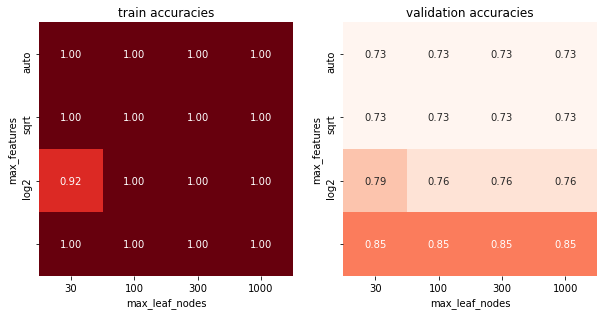

In [69]:
# Trực quan hóa kết quả
train_accs_df = pd.DataFrame(data=np.array(train_accs).reshape(len(max_features), -1),
                             index=max_features, columns=max_leaf_nodes)
val_accs_df = pd.DataFrame(
    data=np.array(val_accs).reshape(len(max_features), -1), 
    index=max_features, columns=max_leaf_nodes)
min_err = min(min(train_accs), min(val_accs))
max_err = max(max(train_accs), max(val_accs))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_accs_df, vmin=min_err, vmax=max_err, square=True, 
            annot=True, cbar=False, fmt='.2f', cmap='Reds')
plt.title('train accuracies'); plt.xlabel('max_leaf_nodes'); plt.ylabel('max_features')
plt.subplot(1, 2, 2)
sns.heatmap(val_accs_df, vmin=min_err, vmax=max_err, square=True, 
            annot=True, cbar=False, fmt='.2f', cmap='Reds')
plt.title('validation accuracies'); plt.xlabel('max_leaf_nodes'); plt.ylabel('max_features');

**Nhận xét:** TỈ lệ trên tập `train` khác biệt hoàn toàn đối với tập `valid`. 
- Theo kinh nghiệm của em, phân lớp bằng cây rất dễ bị hiện tượng `overfitting`, dễ thấy, tỉ lệ ở tập `train` đều đạt điểm tuyệt đối. 
- Đối với tỉ lệ tập `valid`, việc số `features` càng giảm thì có vẻ tỉ lệ khớp càng nhỏ đi. Với trường hợp `max_feautures == None`, ta thấy có giá trị khác rõ với các tham số còn lại. Có vẻ đây là dấu hiệu của việc khớp khá khít. 

---